# Q-learning or Q-network (QN)

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], batch[0][1].shape

([0,
  array([-0.02547154, -0.15850208,  0.00896233,  0.24693023]),
  1.0,
  False,
  {}],
 (4,))

In [6]:
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.44226888453415 -2.8218931717286293


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return actions, states, targetQs

In [9]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [19]:
def model_loss(actions, states, targetQs, # model input
               action_size, hidden_size): # model init
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    # actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    # Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    Qs = tf.reduce_max(actions_logits, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    return actions_logits, loss

In [20]:
def model_opt(loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [21]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [22]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [23]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:', np.max(actions) - np.min(actions)+1)

state size:(1000, 4) actions:(1000,)
action size: 2


In [24]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
gamma = 0.99                   # future reward discount

In [25]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [26]:
state = env.reset()
#for _ in range(batch_size):
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [27]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model): NO
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            # if explore_p > np.random.rand():
            #     action = env.action_space.sample()
            # else:
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state

            # Training
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            next_actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: next_states})
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (gamma * nextQs)
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                     model.actions: actions,
                                                                     model.targetQs: targetQs})
            loss_batch.append(loss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'loss:{:.4f}'.format(np.mean(loss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-qn.ckpt')

Episode:0 meanR:13.0000 R:13.0 loss:1.0008 exploreP:0.9987
Episode:1 meanR:10.5000 R:8.0 loss:0.9947 exploreP:0.9979
Episode:2 meanR:10.0000 R:9.0 loss:0.9977 exploreP:0.9970
Episode:3 meanR:10.0000 R:10.0 loss:0.9948 exploreP:0.9960
Episode:4 meanR:10.0000 R:10.0 loss:0.9999 exploreP:0.9951
Episode:5 meanR:9.6667 R:8.0 loss:0.9709 exploreP:0.9943
Episode:6 meanR:9.4286 R:8.0 loss:0.9806 exploreP:0.9935
Episode:7 meanR:9.5000 R:10.0 loss:1.0060 exploreP:0.9925
Episode:8 meanR:9.3333 R:8.0 loss:1.0016 exploreP:0.9917
Episode:9 meanR:9.4000 R:10.0 loss:0.9979 exploreP:0.9907
Episode:10 meanR:9.4545 R:10.0 loss:0.9758 exploreP:0.9898
Episode:11 meanR:9.5000 R:10.0 loss:0.9722 exploreP:0.9888
Episode:12 meanR:9.3846 R:8.0 loss:0.9905 exploreP:0.9880
Episode:13 meanR:9.2857 R:8.0 loss:0.9900 exploreP:0.9872
Episode:14 meanR:9.3333 R:10.0 loss:1.0164 exploreP:0.9862
Episode:15 meanR:9.3125 R:9.0 loss:1.0021 exploreP:0.9854
Episode:16 meanR:9.3529 R:10.0 loss:1.0176 exploreP:0.9844
Episode:17

Episode:143 meanR:9.3800 R:8.0 loss:15.1010 exploreP:0.8752
Episode:144 meanR:9.3800 R:10.0 loss:8.7463 exploreP:0.8744
Episode:145 meanR:9.3900 R:10.0 loss:7.6888 exploreP:0.8735
Episode:146 meanR:9.3900 R:9.0 loss:7.9697 exploreP:0.8727
Episode:147 meanR:9.3700 R:8.0 loss:10.6966 exploreP:0.8720
Episode:148 meanR:9.3700 R:9.0 loss:11.1862 exploreP:0.8713
Episode:149 meanR:9.3600 R:9.0 loss:13.3030 exploreP:0.8705
Episode:150 meanR:9.3600 R:9.0 loss:10.1714 exploreP:0.8697
Episode:151 meanR:9.3600 R:9.0 loss:12.1426 exploreP:0.8689
Episode:152 meanR:9.3700 R:9.0 loss:11.0176 exploreP:0.8682
Episode:153 meanR:9.3500 R:9.0 loss:13.7891 exploreP:0.8674
Episode:154 meanR:9.3600 R:9.0 loss:10.0587 exploreP:0.8666
Episode:155 meanR:9.3500 R:9.0 loss:11.2360 exploreP:0.8659
Episode:156 meanR:9.3300 R:8.0 loss:11.4126 exploreP:0.8652
Episode:157 meanR:9.3300 R:9.0 loss:9.8648 exploreP:0.8644
Episode:158 meanR:9.3400 R:9.0 loss:8.3833 exploreP:0.8636
Episode:159 meanR:9.3300 R:9.0 loss:9.5365 

Episode:282 meanR:9.2900 R:10.0 loss:8.5720 exploreP:0.7701
Episode:283 meanR:9.2900 R:8.0 loss:10.7712 exploreP:0.7695
Episode:284 meanR:9.3100 R:10.0 loss:6.1588 exploreP:0.7688
Episode:285 meanR:9.3200 R:10.0 loss:5.2950 exploreP:0.7680
Episode:286 meanR:9.3200 R:10.0 loss:7.7886 exploreP:0.7673
Episode:287 meanR:9.3300 R:10.0 loss:6.8769 exploreP:0.7665
Episode:288 meanR:9.3200 R:9.0 loss:2.1351 exploreP:0.7658
Episode:289 meanR:9.3200 R:10.0 loss:9.1456 exploreP:0.7651
Episode:290 meanR:9.3200 R:9.0 loss:10.6817 exploreP:0.7644
Episode:291 meanR:9.3500 R:11.0 loss:3.1285 exploreP:0.7636
Episode:292 meanR:9.3600 R:9.0 loss:2.8729 exploreP:0.7629
Episode:293 meanR:9.3600 R:10.0 loss:10.1984 exploreP:0.7621
Episode:294 meanR:9.3700 R:11.0 loss:4.8343 exploreP:0.7613
Episode:295 meanR:9.3700 R:10.0 loss:6.3011 exploreP:0.7605
Episode:296 meanR:9.3700 R:9.0 loss:4.7957 exploreP:0.7599
Episode:297 meanR:9.3700 R:9.0 loss:6.2101 exploreP:0.7592
Episode:298 meanR:9.3600 R:9.0 loss:7.5896 

Episode:420 meanR:10.0300 R:9.0 loss:2.2178 exploreP:0.6721
Episode:421 meanR:10.0200 R:10.0 loss:2.3149 exploreP:0.6714
Episode:422 meanR:10.0100 R:10.0 loss:3.7263 exploreP:0.6708
Episode:423 meanR:10.0200 R:11.0 loss:2.8140 exploreP:0.6700
Episode:424 meanR:10.0100 R:10.0 loss:3.0836 exploreP:0.6694
Episode:425 meanR:10.0300 R:11.0 loss:3.0185 exploreP:0.6687
Episode:426 meanR:10.0400 R:10.0 loss:2.5660 exploreP:0.6680
Episode:427 meanR:10.0700 R:12.0 loss:1.9579 exploreP:0.6672
Episode:428 meanR:10.0700 R:11.0 loss:2.8653 exploreP:0.6665
Episode:429 meanR:10.0700 R:9.0 loss:2.5427 exploreP:0.6659
Episode:430 meanR:10.1000 R:11.0 loss:2.9708 exploreP:0.6652
Episode:431 meanR:10.0900 R:10.0 loss:3.7926 exploreP:0.6645
Episode:432 meanR:10.0900 R:9.0 loss:2.7700 exploreP:0.6639
Episode:433 meanR:10.0900 R:10.0 loss:3.0777 exploreP:0.6633
Episode:434 meanR:10.1000 R:10.0 loss:3.5875 exploreP:0.6626
Episode:435 meanR:10.0900 R:9.0 loss:3.3273 exploreP:0.6620
Episode:436 meanR:10.0900 R:

Episode:555 meanR:11.5700 R:15.0 loss:2.6779 exploreP:0.5791
Episode:556 meanR:11.6100 R:14.0 loss:2.1824 exploreP:0.5783
Episode:557 meanR:11.6700 R:15.0 loss:2.2539 exploreP:0.5774
Episode:558 meanR:11.6900 R:12.0 loss:2.9819 exploreP:0.5767
Episode:559 meanR:11.7200 R:13.0 loss:2.8916 exploreP:0.5760
Episode:560 meanR:11.7400 R:14.0 loss:2.6619 exploreP:0.5752
Episode:561 meanR:11.7700 R:14.0 loss:2.5869 exploreP:0.5744
Episode:562 meanR:11.7900 R:15.0 loss:2.5158 exploreP:0.5736
Episode:563 meanR:11.8200 R:14.0 loss:2.5754 exploreP:0.5728
Episode:564 meanR:11.8400 R:12.0 loss:2.1229 exploreP:0.5721
Episode:565 meanR:11.9000 R:16.0 loss:2.3823 exploreP:0.5712
Episode:566 meanR:11.9300 R:14.0 loss:2.3637 exploreP:0.5704
Episode:567 meanR:11.9500 R:15.0 loss:1.8461 exploreP:0.5696
Episode:568 meanR:11.9500 R:12.0 loss:1.9815 exploreP:0.5689
Episode:569 meanR:11.9800 R:15.0 loss:2.4947 exploreP:0.5681
Episode:570 meanR:12.0000 R:12.0 loss:2.1393 exploreP:0.5674
Episode:571 meanR:12.050

Episode:690 meanR:42.1100 R:34.0 loss:4.0882 exploreP:0.3650
Episode:691 meanR:42.5400 R:60.0 loss:2.7181 exploreP:0.3629
Episode:692 meanR:42.9600 R:56.0 loss:2.8714 exploreP:0.3609
Episode:693 meanR:43.2500 R:49.0 loss:2.6806 exploreP:0.3592
Episode:694 meanR:43.7100 R:66.0 loss:3.2967 exploreP:0.3569
Episode:695 meanR:44.2100 R:67.0 loss:3.3522 exploreP:0.3546
Episode:696 meanR:44.3500 R:29.0 loss:3.0462 exploreP:0.3536
Episode:697 meanR:44.5500 R:33.0 loss:3.5360 exploreP:0.3524
Episode:698 meanR:44.7400 R:37.0 loss:3.7980 exploreP:0.3512
Episode:699 meanR:44.8700 R:28.0 loss:4.1557 exploreP:0.3502
Episode:700 meanR:45.0000 R:30.0 loss:2.9915 exploreP:0.3492
Episode:701 meanR:45.2700 R:41.0 loss:3.2775 exploreP:0.3478
Episode:702 meanR:45.5200 R:41.0 loss:3.2144 exploreP:0.3464
Episode:703 meanR:45.7700 R:40.0 loss:3.3308 exploreP:0.3451
Episode:704 meanR:45.9500 R:36.0 loss:4.1738 exploreP:0.3439
Episode:705 meanR:46.1200 R:35.0 loss:2.8174 exploreP:0.3427
Episode:706 meanR:46.350

Episode:825 meanR:64.8400 R:52.0 loss:18.6223 exploreP:0.1684
Episode:826 meanR:65.1600 R:79.0 loss:17.0488 exploreP:0.1672
Episode:827 meanR:64.7800 R:51.0 loss:16.9188 exploreP:0.1664
Episode:828 meanR:64.8800 R:53.0 loss:12.6030 exploreP:0.1656
Episode:829 meanR:64.7100 R:56.0 loss:18.4477 exploreP:0.1647
Episode:830 meanR:64.6200 R:76.0 loss:19.4703 exploreP:0.1635
Episode:831 meanR:65.2600 R:93.0 loss:13.5486 exploreP:0.1621
Episode:832 meanR:64.5800 R:67.0 loss:20.0920 exploreP:0.1611
Episode:833 meanR:65.0400 R:78.0 loss:17.3804 exploreP:0.1599
Episode:834 meanR:65.1100 R:49.0 loss:15.6804 exploreP:0.1592
Episode:835 meanR:65.4000 R:61.0 loss:13.8750 exploreP:0.1583
Episode:836 meanR:65.5100 R:44.0 loss:11.5743 exploreP:0.1576
Episode:837 meanR:65.5800 R:48.0 loss:18.0071 exploreP:0.1569
Episode:838 meanR:66.1800 R:106.0 loss:15.5968 exploreP:0.1554
Episode:839 meanR:66.3100 R:67.0 loss:12.3820 exploreP:0.1544
Episode:840 meanR:66.3600 R:51.0 loss:18.6040 exploreP:0.1537
Episode

Episode:957 meanR:201.7800 R:277.0 loss:3.3481 exploreP:0.0272
Episode:958 meanR:204.0500 R:291.0 loss:3.0287 exploreP:0.0267
Episode:959 meanR:205.9000 R:259.0 loss:5.7154 exploreP:0.0262
Episode:960 meanR:208.2400 R:279.0 loss:6.8352 exploreP:0.0258
Episode:961 meanR:210.5400 R:288.0 loss:5.2986 exploreP:0.0253
Episode:962 meanR:210.8100 R:259.0 loss:2.6830 exploreP:0.0250
Episode:963 meanR:213.0200 R:289.0 loss:5.2802 exploreP:0.0245
Episode:964 meanR:215.0600 R:253.0 loss:3.4968 exploreP:0.0242
Episode:965 meanR:217.1000 R:270.0 loss:2.9728 exploreP:0.0238
Episode:966 meanR:217.0800 R:262.0 loss:5.6656 exploreP:0.0234
Episode:967 meanR:219.0500 R:250.0 loss:3.7906 exploreP:0.0231
Episode:968 meanR:220.8500 R:251.0 loss:6.0888 exploreP:0.0228
Episode:969 meanR:223.3700 R:304.0 loss:4.6322 exploreP:0.0224
Episode:970 meanR:225.0400 R:247.0 loss:2.7684 exploreP:0.0221
Episode:971 meanR:227.7600 R:344.0 loss:3.7754 exploreP:0.0217
Episode:972 meanR:229.7300 R:255.0 loss:3.0788 exploreP

Episode:1086 meanR:443.6700 R:500.0 loss:7.5224 exploreP:0.0101
Episode:1087 meanR:446.3300 R:500.0 loss:14.0096 exploreP:0.0101
Episode:1088 meanR:449.0300 R:500.0 loss:10.1352 exploreP:0.0101
Episode:1089 meanR:451.9000 R:500.0 loss:9.2122 exploreP:0.0101
Episode:1090 meanR:454.6700 R:500.0 loss:9.5097 exploreP:0.0101
Episode:1091 meanR:456.8400 R:500.0 loss:10.8539 exploreP:0.0101
Episode:1092 meanR:459.1900 R:500.0 loss:10.9656 exploreP:0.0101
Episode:1093 meanR:461.8400 R:500.0 loss:11.8192 exploreP:0.0101
Episode:1094 meanR:463.6800 R:480.0 loss:11.7687 exploreP:0.0101
Episode:1095 meanR:465.8700 R:500.0 loss:8.4553 exploreP:0.0101
Episode:1096 meanR:467.3100 R:500.0 loss:10.9999 exploreP:0.0101
Episode:1097 meanR:467.7100 R:500.0 loss:11.3234 exploreP:0.0101
Episode:1098 meanR:469.0300 R:370.0 loss:13.1871 exploreP:0.0101
Episode:1099 meanR:468.3300 R:430.0 loss:9.7121 exploreP:0.0100
Episode:1100 meanR:470.4900 R:500.0 loss:14.0835 exploreP:0.0100
Episode:1101 meanR:470.5500 R:

Episode:1214 meanR:387.8400 R:365.0 loss:0.3348 exploreP:0.0100
Episode:1215 meanR:387.8900 R:362.0 loss:2.0144 exploreP:0.0100
Episode:1216 meanR:387.2600 R:425.0 loss:0.2825 exploreP:0.0100
Episode:1217 meanR:387.1200 R:311.0 loss:2.2626 exploreP:0.0100
Episode:1218 meanR:388.1700 R:500.0 loss:0.1870 exploreP:0.0100
Episode:1219 meanR:387.2800 R:411.0 loss:1.5081 exploreP:0.0100
Episode:1220 meanR:388.0800 R:413.0 loss:0.9279 exploreP:0.0100
Episode:1221 meanR:387.1800 R:378.0 loss:0.8186 exploreP:0.0100
Episode:1222 meanR:386.8200 R:356.0 loss:0.9761 exploreP:0.0100
Episode:1223 meanR:385.8300 R:325.0 loss:0.1060 exploreP:0.0100
Episode:1224 meanR:384.7500 R:338.0 loss:2.4334 exploreP:0.0100
Episode:1225 meanR:383.4500 R:346.0 loss:0.2031 exploreP:0.0100
Episode:1226 meanR:381.0800 R:263.0 loss:2.5269 exploreP:0.0100
Episode:1227 meanR:381.2000 R:340.0 loss:0.1121 exploreP:0.0100
Episode:1228 meanR:382.6100 R:450.0 loss:1.0310 exploreP:0.0100
Episode:1229 meanR:383.8300 R:445.0 loss

Episode:1343 meanR:366.6100 R:401.0 loss:0.4821 exploreP:0.0100
Episode:1344 meanR:365.6700 R:362.0 loss:0.4768 exploreP:0.0100
Episode:1345 meanR:365.6300 R:346.0 loss:0.5629 exploreP:0.0100
Episode:1346 meanR:365.1800 R:393.0 loss:0.3585 exploreP:0.0100
Episode:1347 meanR:364.1000 R:392.0 loss:0.7060 exploreP:0.0100
Episode:1348 meanR:363.8200 R:472.0 loss:0.2936 exploreP:0.0100
Episode:1349 meanR:362.6500 R:339.0 loss:0.2065 exploreP:0.0100
Episode:1350 meanR:362.4500 R:340.0 loss:0.4208 exploreP:0.0100
Episode:1351 meanR:362.3900 R:332.0 loss:0.2105 exploreP:0.0100
Episode:1352 meanR:361.7100 R:351.0 loss:0.6685 exploreP:0.0100
Episode:1353 meanR:360.6400 R:393.0 loss:0.6167 exploreP:0.0100
Episode:1354 meanR:360.2200 R:441.0 loss:0.5113 exploreP:0.0100
Episode:1355 meanR:358.9600 R:374.0 loss:0.5217 exploreP:0.0100
Episode:1356 meanR:357.8400 R:364.0 loss:0.9397 exploreP:0.0100
Episode:1357 meanR:357.6200 R:364.0 loss:1.0255 exploreP:0.0100
Episode:1358 meanR:355.8600 R:324.0 loss

Episode:1473 meanR:232.0100 R:10.0 loss:33.4553 exploreP:0.0100
Episode:1474 meanR:227.9400 R:9.0 loss:1.8912 exploreP:0.0100
Episode:1475 meanR:224.1200 R:10.0 loss:16.1425 exploreP:0.0100
Episode:1476 meanR:219.2200 R:10.0 loss:49.6966 exploreP:0.0100
Episode:1477 meanR:214.9900 R:11.0 loss:43.6276 exploreP:0.0100
Episode:1478 meanR:211.0900 R:9.0 loss:3.0508 exploreP:0.0100
Episode:1479 meanR:206.1800 R:9.0 loss:30.6648 exploreP:0.0100
Episode:1480 meanR:201.2900 R:11.0 loss:3.7676 exploreP:0.0100
Episode:1481 meanR:196.3900 R:10.0 loss:4.0374 exploreP:0.0100
Episode:1482 meanR:192.5900 R:10.0 loss:3.7764 exploreP:0.0100
Episode:1483 meanR:190.0600 R:10.0 loss:3.6644 exploreP:0.0100
Episode:1484 meanR:187.5800 R:10.0 loss:17.9719 exploreP:0.0100
Episode:1485 meanR:184.9700 R:9.0 loss:3.1788 exploreP:0.0100
Episode:1486 meanR:181.8800 R:9.0 loss:35.5655 exploreP:0.0100
Episode:1487 meanR:176.9800 R:10.0 loss:3.3653 exploreP:0.0100
Episode:1488 meanR:173.4300 R:12.0 loss:3.3608 explor

Episode:1606 meanR:12.8600 R:17.0 loss:15.0896 exploreP:0.0100
Episode:1607 meanR:12.9400 R:19.0 loss:16.9460 exploreP:0.0100
Episode:1608 meanR:13.0000 R:16.0 loss:22.7898 exploreP:0.0100
Episode:1609 meanR:13.1100 R:21.0 loss:19.2127 exploreP:0.0100
Episode:1610 meanR:13.1800 R:18.0 loss:18.6239 exploreP:0.0100
Episode:1611 meanR:13.2600 R:19.0 loss:18.3123 exploreP:0.0100
Episode:1612 meanR:13.3000 R:16.0 loss:16.7955 exploreP:0.0100
Episode:1613 meanR:13.3700 R:19.0 loss:22.4353 exploreP:0.0100
Episode:1614 meanR:13.4300 R:16.0 loss:14.6105 exploreP:0.0100
Episode:1615 meanR:13.5100 R:20.0 loss:16.7763 exploreP:0.0100
Episode:1616 meanR:13.6100 R:21.0 loss:16.8351 exploreP:0.0100
Episode:1617 meanR:13.7200 R:22.0 loss:17.9005 exploreP:0.0100
Episode:1618 meanR:13.7900 R:18.0 loss:17.0307 exploreP:0.0100
Episode:1619 meanR:13.8700 R:18.0 loss:15.1348 exploreP:0.0100
Episode:1620 meanR:13.9500 R:21.0 loss:15.5913 exploreP:0.0100
Episode:1621 meanR:14.0200 R:18.0 loss:19.2912 exploreP

Episode:1738 meanR:96.8600 R:12.0 loss:28.5036 exploreP:0.0100
Episode:1739 meanR:96.6600 R:14.0 loss:21.9142 exploreP:0.0100
Episode:1740 meanR:96.5100 R:13.0 loss:4.3628 exploreP:0.0100
Episode:1741 meanR:96.2000 R:14.0 loss:14.6020 exploreP:0.0100
Episode:1742 meanR:95.9800 R:11.0 loss:2.1953 exploreP:0.0100
Episode:1743 meanR:95.7400 R:13.0 loss:26.2723 exploreP:0.0100
Episode:1744 meanR:95.3000 R:10.0 loss:3.6574 exploreP:0.0100
Episode:1745 meanR:94.9200 R:12.0 loss:2.7680 exploreP:0.0100
Episode:1746 meanR:94.5400 R:12.0 loss:3.0797 exploreP:0.0100
Episode:1747 meanR:94.2100 R:12.0 loss:8.2405 exploreP:0.0100
Episode:1748 meanR:93.7200 R:10.0 loss:26.8130 exploreP:0.0100
Episode:1749 meanR:93.3000 R:13.0 loss:13.6397 exploreP:0.0100
Episode:1750 meanR:92.9100 R:11.0 loss:5.6280 exploreP:0.0100
Episode:1751 meanR:92.2800 R:12.0 loss:8.8020 exploreP:0.0100
Episode:1752 meanR:91.8200 R:10.0 loss:2.4814 exploreP:0.0100
Episode:1753 meanR:91.3100 R:12.0 loss:4.5370 exploreP:0.0100
Ep

Episode:1870 meanR:14.9200 R:23.0 loss:10.3150 exploreP:0.0100
Episode:1871 meanR:15.0500 R:24.0 loss:10.6731 exploreP:0.0100
Episode:1872 meanR:15.1700 R:23.0 loss:8.5365 exploreP:0.0100
Episode:1873 meanR:15.2000 R:15.0 loss:9.4054 exploreP:0.0100
Episode:1874 meanR:15.3000 R:24.0 loss:10.0586 exploreP:0.0100
Episode:1875 meanR:15.4200 R:23.0 loss:9.6794 exploreP:0.0100
Episode:1876 meanR:15.4500 R:18.0 loss:9.8333 exploreP:0.0100
Episode:1877 meanR:15.4800 R:16.0 loss:11.5885 exploreP:0.0100
Episode:1878 meanR:15.5500 R:20.0 loss:14.2492 exploreP:0.0100
Episode:1879 meanR:15.6500 R:24.0 loss:8.9708 exploreP:0.0100
Episode:1880 meanR:15.7300 R:20.0 loss:9.5498 exploreP:0.0100
Episode:1881 meanR:15.8700 R:27.0 loss:10.5839 exploreP:0.0100
Episode:1882 meanR:16.0200 R:25.0 loss:11.8789 exploreP:0.0100
Episode:1883 meanR:16.1300 R:22.0 loss:9.4662 exploreP:0.0100
Episode:1884 meanR:16.2200 R:22.0 loss:8.6332 exploreP:0.0100
Episode:1885 meanR:16.2900 R:20.0 loss:9.1890 exploreP:0.0100
E

Episode:2001 meanR:106.7300 R:81.0 loss:0.4188 exploreP:0.0100
Episode:2002 meanR:106.7200 R:74.0 loss:0.3951 exploreP:0.0100
Episode:2003 meanR:106.7500 R:76.0 loss:0.3482 exploreP:0.0100
Episode:2004 meanR:107.0000 R:100.0 loss:0.3264 exploreP:0.0100
Episode:2005 meanR:107.2100 R:93.0 loss:0.3880 exploreP:0.0100
Episode:2006 meanR:107.2700 R:83.0 loss:0.3524 exploreP:0.0100
Episode:2007 meanR:107.3500 R:87.0 loss:0.3338 exploreP:0.0100
Episode:2008 meanR:107.2400 R:74.0 loss:0.3061 exploreP:0.0100
Episode:2009 meanR:107.5700 R:112.0 loss:0.2659 exploreP:0.0100
Episode:2010 meanR:107.6500 R:88.0 loss:0.3480 exploreP:0.0100
Episode:2011 meanR:107.6600 R:78.0 loss:0.3342 exploreP:0.0100
Episode:2012 meanR:107.5300 R:75.0 loss:0.3077 exploreP:0.0100
Episode:2013 meanR:107.5300 R:80.0 loss:0.2760 exploreP:0.0100
Episode:2014 meanR:107.9200 R:114.0 loss:0.3178 exploreP:0.0100
Episode:2015 meanR:108.0200 R:85.0 loss:0.2867 exploreP:0.0100
Episode:2016 meanR:107.9200 R:81.0 loss:0.3031 explo

Episode:2130 meanR:170.2500 R:161.0 loss:2.6641 exploreP:0.0100
Episode:2131 meanR:174.3500 R:500.0 loss:3.1864 exploreP:0.0100
Episode:2132 meanR:178.5900 R:500.0 loss:2.7818 exploreP:0.0100
Episode:2133 meanR:180.9100 R:328.0 loss:4.0896 exploreP:0.0100
Episode:2134 meanR:184.8500 R:500.0 loss:4.1891 exploreP:0.0100
Episode:2135 meanR:189.0200 R:500.0 loss:5.2311 exploreP:0.0100
Episode:2136 meanR:191.5900 R:337.0 loss:5.0558 exploreP:0.0100
Episode:2137 meanR:192.8400 R:227.0 loss:5.5733 exploreP:0.0100
Episode:2138 meanR:194.5100 R:287.0 loss:8.8600 exploreP:0.0100
Episode:2139 meanR:194.8300 R:111.0 loss:4.2093 exploreP:0.0100
Episode:2140 meanR:198.8900 R:500.0 loss:2.6653 exploreP:0.0100
Episode:2141 meanR:203.0600 R:500.0 loss:5.2950 exploreP:0.0100
Episode:2142 meanR:206.8800 R:500.0 loss:5.9021 exploreP:0.0100
Episode:2143 meanR:210.8600 R:500.0 loss:6.4929 exploreP:0.0100
Episode:2144 meanR:214.1900 R:463.0 loss:5.2658 exploreP:0.0100
Episode:2145 meanR:218.1900 R:500.0 loss

Episode:2258 meanR:323.2700 R:77.0 loss:7.9029 exploreP:0.0100
Episode:2259 meanR:322.2800 R:57.0 loss:18.1678 exploreP:0.0100
Episode:2260 meanR:317.9300 R:65.0 loss:9.8300 exploreP:0.0100
Episode:2261 meanR:313.8200 R:89.0 loss:18.5741 exploreP:0.0100
Episode:2262 meanR:313.8700 R:106.0 loss:6.5728 exploreP:0.0100
Episode:2263 meanR:316.7900 R:410.0 loss:10.8131 exploreP:0.0100
Episode:2264 meanR:314.4800 R:269.0 loss:12.8254 exploreP:0.0100
Episode:2265 meanR:318.5500 R:500.0 loss:9.2571 exploreP:0.0100
Episode:2266 meanR:317.8300 R:428.0 loss:6.8922 exploreP:0.0100
Episode:2267 meanR:321.5300 R:500.0 loss:12.5723 exploreP:0.0100
Episode:2268 meanR:321.8400 R:187.0 loss:11.6424 exploreP:0.0100
Episode:2269 meanR:321.8400 R:500.0 loss:10.1543 exploreP:0.0100
Episode:2270 meanR:321.7500 R:127.0 loss:12.2833 exploreP:0.0100
Episode:2271 meanR:322.0000 R:136.0 loss:6.5034 exploreP:0.0100
Episode:2272 meanR:318.7100 R:171.0 loss:6.0147 exploreP:0.0100
Episode:2273 meanR:319.1200 R:167.0 

Episode:2386 meanR:437.2400 R:500.0 loss:13.2797 exploreP:0.0100
Episode:2387 meanR:440.9500 R:500.0 loss:14.1109 exploreP:0.0100
Episode:2388 meanR:442.1100 R:500.0 loss:14.9778 exploreP:0.0100
Episode:2389 meanR:446.1900 R:500.0 loss:13.8332 exploreP:0.0100
Episode:2390 meanR:446.1900 R:500.0 loss:15.5303 exploreP:0.0100
Episode:2391 meanR:446.1900 R:500.0 loss:13.1175 exploreP:0.0100
Episode:2392 meanR:446.1900 R:500.0 loss:8.8328 exploreP:0.0100
Episode:2393 meanR:446.1900 R:500.0 loss:15.3338 exploreP:0.0100
Episode:2394 meanR:446.1900 R:500.0 loss:14.6807 exploreP:0.0100
Episode:2395 meanR:450.8900 R:500.0 loss:13.9328 exploreP:0.0100
Episode:2396 meanR:450.8900 R:500.0 loss:12.8104 exploreP:0.0100
Episode:2397 meanR:454.7900 R:500.0 loss:15.1157 exploreP:0.0100
Episode:2398 meanR:454.7900 R:500.0 loss:11.1723 exploreP:0.0100
Episode:2399 meanR:454.7900 R:500.0 loss:10.5705 exploreP:0.0100
Episode:2400 meanR:454.7900 R:500.0 loss:15.5304 exploreP:0.0100
Episode:2401 meanR:454.790

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

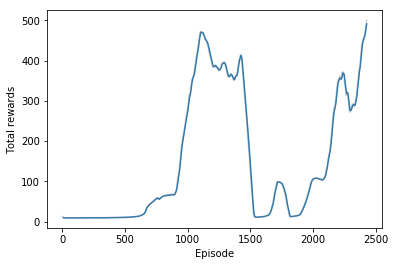

In [29]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

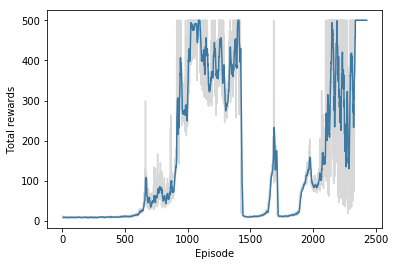

In [30]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Average losses')

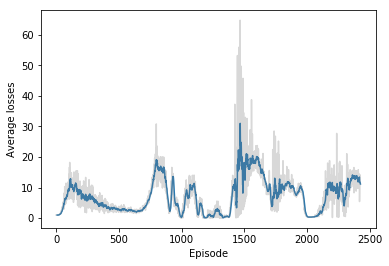

In [31]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [32]:
# Creating a gym env
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-qn.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))
# Close the env at the end
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model-qn.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.